In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
categories = pd.read_csv('categories.csv', encoding = "ISO-8859-1")
reviews = pd.read_csv('reviews.csv', encoding = "ISO-8859-1")
reviews['helpfulness'] = reviews['HELPFUL']/reviews['VOTES']

reviews = reviews.drop('Unnamed: 0', 1)
categories = categories.drop('Unnamed: 0', 1)


In [3]:
rank_group = pd.read_csv('rank_and_group.csv', encoding = "ISO-8859-1")
rank_group = rank_group.set_index('ID')
similiar = pd.read_csv('similar.csv', encoding = "ISO-8859-1")
rank_group.loc[rank_group['rank']<=0,"rank"] = 0 #fix < 1

# 1. Trustworthiness of ratings
Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?


## Create Pivot for Rating Summary

In [5]:
run = 0
if run == 1:
    df_rating_summary = reviews.pivot_table(index = "PROD_ID", values = ['RATING','helpfulness'], aggfunc = [np.mean,len])
    df_rating_summary.columns = ['mean_rating','mean_helpfulness','ct_rating','ct_helpful']
    df_rating_summary = df_rating_summary.drop("ct_helpful",1)
    df_rating_summary = df_rating_summary.merge(rank_group, left_index = True, right_index = True)
    df_rating_summary = df_rating_summary.dropna()
    df_rating_summary = df_rating_summary[df_rating_summary.group.isin(['Book','DVD','Music','Video'])] # Remove Low Frequency
    df_rating_summary.to_csv("rating_summary.csv", index = False)
else:
    df_rating_summary = pd.read_csv("rating_summary.csv")


## Exploratory Data Analysis

Group Count

In [6]:
to_plot = df_rating_summary
to_plot.groupby('group')['mean_rating','mean_helpfulness'].size()

group
Book     268190
DVD       18249
Music     79630
Video     21911
dtype: int64

##### PairPlot: Scatter Matrix on Key Variables
- High frequency in high and helpful ratings for books and music -- might signal that these are genres where there are a lot of 
interest where some proprtion is driven by bias
- Almost "bimodal" nature in ratings vs rank and helpfulness vs rank:
    - Books: Lots of extreme ratings
- More ratings seen a helpfuless rating reach .5 (conical shape)


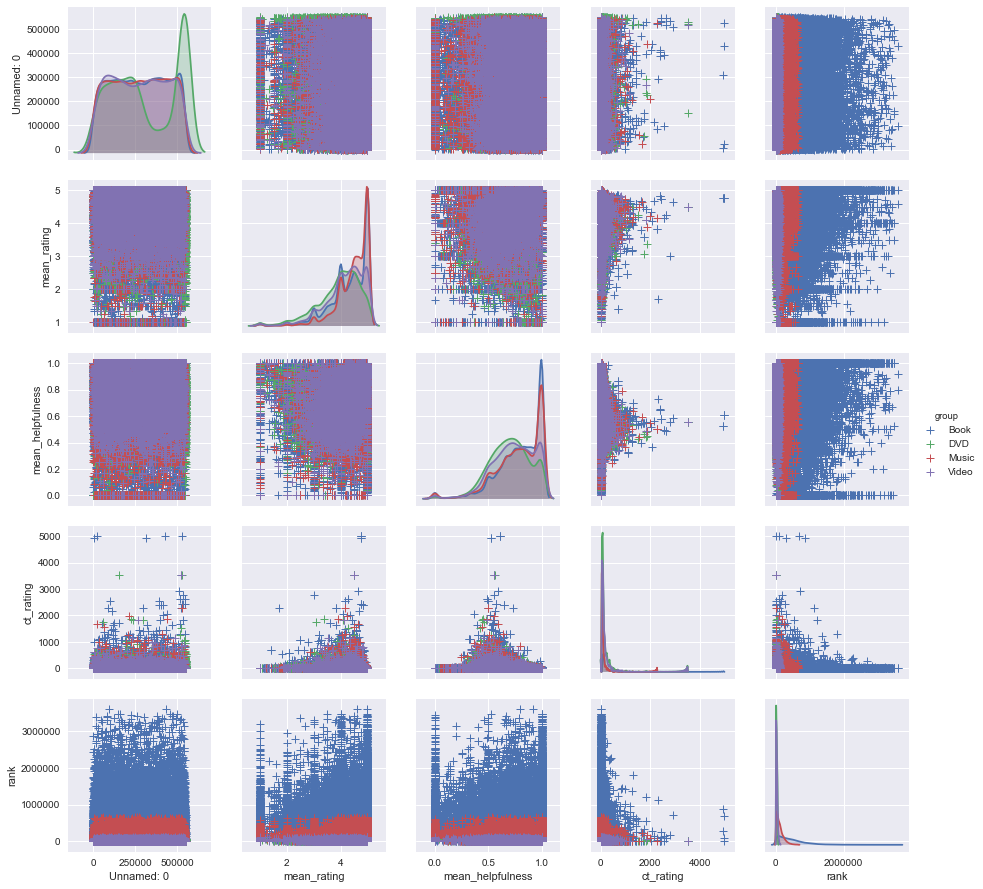

In [7]:
to_plot = df_rating_summary.sample(100000)
sns.pairplot(to_plot, diag_kind="kde", markers="+",hue="group",
             plot_kws=dict(s=50, edgecolor="b", linewidth=1),
             diag_kws=dict(shade=True))

#### Sales Rank vs Helpfulness and Ratings

Helpfulness is defined as (# Voted Helpful) / (Total Votes). The data below are binned into 30 "rank" buckets. 

Looking at books, we can see that as rank increases, the helpfulness of ratings deteriorate. This signals potentially bad / bias reviews. In addition, the sales rank increases also are associated with reduction of rating.

Music interstingly sees a dip on both sides suggesting that helpfuless for high and low ranking sales are associated with bad / bias reviews. Interestingly, both sides show a high rating. This is an area for investigation. For example, I would suggesting investigting the type of individuals who rate these -- do we seem them rating similarly in other ranking bins?

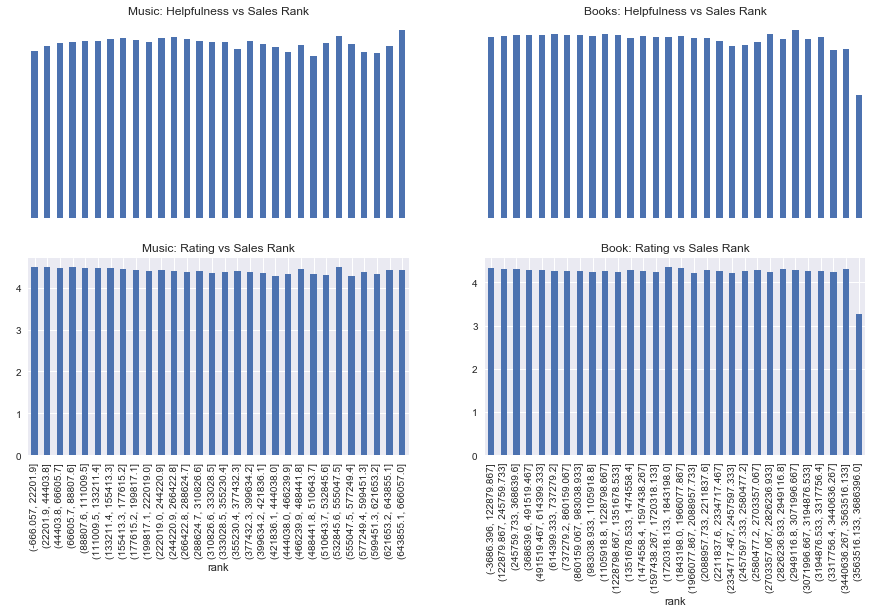

In [8]:
plt.figure(figsize = (15,8))
plt.subplot(2,2,1)
bars_1 = df_rating_summary[df_rating_summary.group == 'Music'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_1['rank'] = pd.cut(bars_1['rank'], 30)
bars_1.groupby('rank')['mean_helpfulness'].mean().plot(kind = 'bar')
plt.axis('off')
plt.title('Music: Helpfulness vs Sales Rank')

plt.subplot(2,2,2)
bars_2 = df_rating_summary[df_rating_summary.group == 'Book'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_2['rank'] = pd.cut(bars_2['rank'], 30)
bars_2.groupby('rank')['mean_helpfulness'].mean().plot(kind = 'bar')
plt.axis('off')
plt.title('Books: Helpfulness vs Sales Rank')

plt.subplot(2,2,3)
bars_1 = df_rating_summary[df_rating_summary.group == 'Music'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_1['rank'] = pd.cut(bars_1['rank'], 30)
bars_1.groupby('rank')['mean_rating'].mean().plot(kind = 'bar')
plt.title('Music: Rating vs Sales Rank')

plt.subplot(2,2,4)
bars_1 = df_rating_summary[df_rating_summary.group == 'Book'].sort_values('rank', ascending = False)[['rank','mean_helpfulness','mean_rating','group']]
bars_1['rank'] = pd.cut(bars_1['rank'], 30)
bars_1.groupby('rank')['mean_rating'].mean().plot(kind = 'bar')
plt.title('Book: Rating vs Sales Rank')

plt.show()

# 2. Category bloat
Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.

For this dataset, quantify the following:

a. Is there redundancy in the categorization? How can it be identified/removed?
- Yes, in that there may be categories that are "too specific" see that analysis below that shows redundant categories -- these are items with only one instance that could be collapsed into others. 

- Another method is taking each "deepest level" category and running a correlation against all other categories. Consider those with the highest level.

For example, in the following hypothetical Say 20 of 20 books are categorized as:
Books (1) > history(2) > US History (3) -- 20 books
Books (1) > literature(2) > American History (3) -- 20 of the same books

If we construct a programt that cycles through each level, say starting with the deepest at 3 (selects all products with 3 levels). Then runs a correlation matrix so that in the above example we get correlation(US History, American History) = 1. 

We begin to see that highly correlated categories are potentials for removal.


b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?



In [10]:
indexed = categories.groupby(['PROD_ID'])['CATEGORY_ORDER'].transform(max) == categories['CATEGORY_ORDER']

In [63]:
categories_rare = categories[indexed].groupby("DESC").size().sort_values(ascending = True)
categories_rare = categories_rare[categories_rare == 1]
single_instance_categories = categories_rare[~categories_rare.index.str.contains(",")]

#top and bottom 5
single_instance_categories.head().append(single_instance_categories.tail()) 

DESC
Intel                        1
Cleveland                    1
Revenge                      1
Insight Pocket Guide         1
Insomniac                    1
Begonias                     1
The Year I Turned Sixteen    1
Beethoven                    1
Belita                       1
Football & Hockey            1
dtype: int64

Drop all duplicated paths, example:

Books > History > latin

Books > History > South american

fuzzy match test

In [220]:
words = categories.sample(1000).dropna().DESC.unique()

In [221]:
words = categories.sample(500).dropna().DESC.unique()
collect = []
for first_word in words:
    words_to_search = [i for i in words if i not in first_word]
    for second_word in words_to_search:
        collect.append([first_word, second_word, fuzz.partial_ratio(first_word, second_word)])

In [222]:
collected = pd.DataFrame(collect, columns = ['firstword','secondword','match'])

In [223]:
collected[collected.groupby('firstword')['match'].transform(max) == collected['match']].sort_values('match',ascending = False).query("match > 90")

,firstword,secondword,match
194,General,Classical General,100
8955,Art,Arts & Photography,100
2725,DVD,DVD Outlet,100
2787,DVD,Today's Deals in DVD,100
5524,Genres,Forms & Genres,100
5774,Books,Picture Books,100
5779,Books,Children's Books,100
5783,Books,Travel Books,100
5898,Books,"Books, Music & More",100
5924,Books,Publishing & Books,100
